In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn.decomposition import PCA

import statsmodels.api as sm

## Load data

In [2]:
## Load data

gss = pd.read_csv('../../GSS_2012/ICPSR_35478/DS0001/35478-0001-Data.tsv', sep='\t')
print(gss.shape)
gss.head()

(4820, 1069)


,YEAR,ID,INTID,FEEUSED,FEELEVEL,DATEINTV,LNGTHINV,INTAGE,INTETHN,MODE,...,SAMPCODE,SAMPLE,OVERSAMP,WTSS,WTSSNR,WTSSALL,WTCOMB,WTCOMBNR,VSTRAT,VPSU
0,2012,1,49,1,75,721,69,60,1,1,...,601,10,1,2.621963,2.869532,2.621963,6.402159,7.006659,-1,-1
1,2012,2,150,1,75,624,53,32,1,1,...,601,10,1,3.495950,3.826043,3.495950,6.514477,7.129583,-1,-1
2,2012,3,150,1,75,627,77,32,1,1,...,601,10,1,1.747975,1.913021,1.747975,1.671130,1.828920,-1,-1
3,2012,4,49,1,20,527,78,60,1,1,...,601,10,1,1.235694,1.352370,1.235694,1.181370,1.292917,-1,-1
4,2012,5,235,1,75,620,149,62,1,1,...,601,10,1,0.873988,0.956511,0.873988,0.835565,0.914460,-1,-1


## Select useful features manually

In [3]:
## Most useful features with majority responses

gss_select = pd.DataFrame({
    'age': gss['AGE'], #p60
    'yob': gss['COHORT'],
    'sex': gss['SEX'], #p87
    'race': gss['RACECEN1'], #p291
    'siblings': gss['SIBS'], #p58
    'region': gss['REGION'], #p103
    'place_size_000s': gss['SIZE'], #p105
    'place_size': gss['XNORCSIZ'], #p104
    'beltcode': gss['SRCBELT'], #p105
    'work_status': gss['WRKSTAT'],
    'hours': gss['HRS1'], #p.21
    'self_employed': gss['WRKSLF'],
    'occupation': gss['OCC10'],
    'income': gss['RINCOME'], #p100
    'income_granular': gss['RINCOM06'], #p102
    'highest_school': gss['EDUC'], #p64
    'highest_degree': gss['DEGREE'], #p68
    'major': gss['MAJOR1'], #p70
    'residence_16' : gss['RES16'], #p88
    'region_16': gss['REG16'], #p89
    'family_16': gss['FAMILY16'], #90
    'live_who_16': gss['FAMDIF16'], #91
    'fam_income_16': gss['INCOM16'], #92
    'relig_raised': gss['RELIG16'], #p.186
    'geo_mobility': gss['MOBILE16'], #p90
    'mother_employed': gss['MAWRKGRW'], #92
    'father_school': gss['PAEDUC'], #p65
    'mother_school': gss['MAEDUC'], #p66
    'father_degree': gss['PADEG'], #p68
    'mother_degree': gss['MADEG'], #p69
    'father_occupation': gss['PAOCC10'], #p.45
    'mother_occupation': gss['MAOCC10'], #p51
    'father_self_employed': gss['PAWRKSLF'], #p.45
    'mother_self_employed': gss['MAWRKSLF'], #p51
    'class': gss['CLASS'], #p.236
    'happiness': gss['HAPPY'], #p210
    'pol_party': gss['PARTYID'], #p140
    'pol_views': gss['POLVIEWS'], #p142
    'vote_2008': gss['VOTE08'], #p140
    'pres_2008': gss['PRES08'], #p141
    'if_pres_2008': gss['IF08WHO'], #P141
    'religion': gss['RELIG'], #p.175
    'religion_strength': gss['RELITEN'], #p183
    'fundamentalist': gss['FUND'], #p182
    'rel_attend': gss['ATTEND'], #p182
    'rel_person': gss['RELPERSN'],
    'spi_person': gss['SPRTPRSN'],
    'post_life': gss['POSTLIFE'], #p184
    'pray': gss['PRAY'], #p184
    'bible': gss['BIBLE'], #p206
    'god': gss["GOD"],
    'born_again': gss['REBORN'],
    'save_soul': gss['SAVESOUL'],
    'rel_activities': gss['RELACTIV'],
    'op_road': gss['NATROAD'], #p149
    'op_socsec': gss['NATSOC'], #p150
    'op_masstrans': gss['NATMASS'], #p151
    'op_parks': gss['NATPARK'], #p152
    'op_childcare': gss['NATCHLD'], #p153
    'op_scires': gss['NATSCI'], #p154
    'op_cappun': gss['CAPPUN'], #p173
    'op_gunlaws': gss['GUNLAW'], #173
    'op_criminals': gss['COURTS'] #p174
    
})

In [4]:
## Features that might have label leakage

gss_may_hint = pd.DataFrame({
    'dwelling_type': gss['DWELLING'], #p295
    'children': gss['CHILDS'], #p59
    'age_1st_child': gss['AGEKDBRN'], #P62
    'sex_orient': gss['SEXORNT'] #p277
})

In [5]:
## Outcome variable

gss_marital_status = pd.DataFrame({
    'marital_status' : gss['MARITAL'],
    'ever_divorced' : gss['DIVORCE'],
    'ever_widowed' : gss['WIDOWED']
})

In [6]:
## marital_status: 1-Married, 2-Widowed, 3-Divorced, 4-Separated, 5-Never married, 9-No answer
## ever_divorced: 1-Yes, 2-No, 0-Inapplicable, 8-Don't know, 9-No answer
## ever_widowed: 1-Yes, 2-No, 0-Inapplicable, 8-Don't know, 9-No answer
gss_marital_status.head()

,marital_status,ever_divorced,ever_widowed
0,5,0,0
1,5,0,0
2,1,2,2
3,1,1,2
4,4,0,2


In [7]:
## Create binary outcome variable

gss_divsep = pd.DataFrame({
    'ever_divsep': np.where(gss_marital_status['marital_status'].isin([3, 4]), 1, 0) + np.where(gss_marital_status['ever_divorced'] == 1, 1, 0)
})

In [8]:
gss_divsep.head()

,ever_divsep
0,0
1,0
2,0
3,1
4,1


In [9]:
## Why so many non responses for income?

gss_income = gss.loc[gss['RINCOM06'] == 0, ]

In [10]:
gss_income.VERSION.value_counts()

2    619
3    577
1    566
Name: VERSION, dtype: int64

In [11]:
gss_income.SAMPTYPE.value_counts()

2012    723
2010    567
2008    472
Name: SAMPTYPE, dtype: int64

## Create features and record NAs

In [12]:
## Create features and record NAs

In [13]:
dummies_needed = []
gss_features = pd.DataFrame()
gss_nas = pd.DataFrame({
    'variable': gss_select.columns,
    'inapplicable': np.nan,
    'dont_know': np.nan,
    'no_answer': np.nan
})

gss_nas.set_index(['variable'], drop=True, inplace=True)
gss_nas.head()

,inapplicable,dont_know,no_answer
variable,,,
age,NaN,NaN,NaN
yob,NaN,NaN,NaN
sex,NaN,NaN,NaN
race,NaN,NaN,NaN
siblings,NaN,NaN,NaN


In [14]:
## Filling in gss_nas

def fill_gn(row, col, value):
    gss_nas.loc[row, col] = (gss_select[row] == value).sum()
    

#### Age

In [15]:
## Fill in NAs
gss_nas.loc['age', 'dont_know'] = (gss_select['age'] == 98).sum()
fill_gn('age', 'no_answer', 99)

## Create feature with NAs
gss_features['age'] = np.where(gss_select['age'] == 99, np.nan, gss_select['age'])

## Display results
print(gss_nas.head())
print(gss_features.head())

          inapplicable  dont_know  no_answer
variable                                    
age                NaN        0.0       51.0
yob                NaN        NaN        NaN
sex                NaN        NaN        NaN
race               NaN        NaN        NaN
siblings           NaN        NaN        NaN
    age
0  22.0
1  21.0
2  42.0
3  49.0
4  70.0


#### YOB

In [16]:
## Ignoring this as duplicates age

#### Sex (p.87)

In [17]:
## 1-Male, 2-Female in survey
## Code to 0-Female, 1-Male

gss_features['sex'] = np.where(gss_select['sex'] == 2, 0, 1)

#### Race (p.291)

In [18]:
fill_gn('race', 'dont_know', 98)
fill_gn('race', 'no_answer', 99)

## If less than 1% code as other
race_dict = {
    1: 'white',
    2: 'black',
    3: 'american_indian',
    4: 'other', #'asian indian', 
    5: 'other', #'chinese', 
    6: 'other', #'filipino', 
    7: 'other', #'japanese', 
    8: 'other', #'korean', 
    9: 'other', # vietnamese
    10: 'other', #other asian 
    11: 'other', #native hawaiian 
    12: 'other', #Guamanian or Chamorro 
    13: 'other', #Samoan 
    14: 'other', #Other pacific islander 
    15: 'other', #another race 
    16: 'hispanic', 
    98: 'other',
    99: 'other'
}

gss_features['race'] = gss_select['race'].replace(race_dict)
dummies_needed.append('race')

## Can code 98 and 99 as 'other' because if obvious interviewer codes it.

#### Siblings p.58

In [19]:
fill_gn('siblings', 'dont_know', 98)
fill_gn('siblings', 'no_answer', 99)
gss_features['siblings'] = np.where(gss_select['siblings'].isin([98, 99]), np.nan, gss_select['siblings'])

#### Region p.103

In [20]:
region_dict = {
    1: 'New_England',
    2: 'Middle_Atlantic',
    3: 'East_North_Central',
    4: 'West_North_Central',
    5: 'South_Atlantic',
    6: 'East_South_Central',
    7: 'West_South_Central',
    8: 'Mountain',
    9: 'Pacific',
    0: np.nan
}

fill_gn('region', 'no_answer', 0)

gss_features['region'] = gss_select['region'].replace(region_dict)

dummies_needed.append('region')

#### Place size 000s p.105

In [21]:
gss_select.loc[gss_select['place_size_000s'] <0,]

,age,yob,sex,race,siblings,region,place_size_000s,place_size,beltcode,work_status,...,rel_activities,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_gunlaws,op_criminals


In [22]:
## No missing values (-1) so no cleaning needed

gss_features['place_size_000s'] = gss_select['place_size_000s']

#### Place size p.104

In [23]:
## Not used - replicates previous

#### Beltcode p.105

In [24]:
## Use this to code urban / suburban / countryside

urban_dict = {
    1: 'urban',
    2: 'urban',
    3: 'suburban',
    4: 'suburban',
    5: 'urban',
    6: 'rural', 
}

gss_features['beltcode'] = gss_select['beltcode'].replace(urban_dict)

dummies_needed.append('beltcode')

#### Work status p.20

In [25]:
## Potential leakage here from keeping house and part time. Ignore.

#### Hours worked last week p.21

In [26]:
## -1 is inapplicable, 98 is don't know, 99 is no answer

fill_gn('hours', 'inapplicable', -1)
fill_gn('hours', 'dont_know', 98)
fill_gn('hours', 'no_answer', 99)

gss_features['hours_worked'] = gss_select['hours']

gss_features.loc[gss_features['hours_worked'] == -1, 'hours_worked'] = 0

gss_features.loc[gss_features['hours_worked'].isin([98,99]), 'hours_worked'] = np.nan


#### Self employed p.25

In [27]:
## Only 131 inapplicables doesn't make sense with work status results.
## Leave out.

#### Occupation p.26

In [28]:
## The numbers do not tally with the totals for each occupation in 
## appendix F. Maybe Appendix F doesn't include all panels?

len(gss['OCC10'].unique())

421

In [29]:
occs = gss_select['occupation'].value_counts().to_frame('counts').sort_values('counts', ascending=False)
occs['percentage'] = occs['counts'] / occs['counts'].sum()
occs.loc[occs['percentage'] > 0.015,]

,counts,percentage
5700,145,0.030083
0,131,0.027178
4760,110,0.022822
4220,110,0.022822
3600,108,0.022407
2310,101,0.020954
9130,96,0.019917
3255,96,0.019917
430,94,0.019502
5240,76,0.015768


In [30]:
## Too small, would create noise - code by general occupation area.

occ_dict = {
    0: 'none',
    430: 'manager',
    950: 'business',
    1240: 'computers_maths',
    1560: 'engineering',
    1965: 'science',
    2060: 'social_services',
    2160: 'legal',
    2550: 'education',
    2960: 'arts',
    3540: 'healthcare_technical',
    3600: 'healthcare_support',
    3955: 'protective_services',
    4160: 'food_prep_serving',
    4250: 'cleaning_maintenance',
    4650: 'personal_care',
    4965: 'sales',
    5940: 'administrative_support',
    6130: 'farming_fishing_forestry',
    6940: 'construction',
    7630: 'installation',
    8965: 'production',
    9750: 'transportation',
    9830: 'military',
    9999: np.nan
    
}

gss_occs = pd.DataFrame()
gss_occs['occs'] = gss_select['occupation']
gss_occs['occs_summary'] = gss_occs['occs']

for occ in occ_dict:
    for row in np.arange(0, len(gss_occs)):
        if(isinstance(gss_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_occs.loc[row, 'occs_summary'] <= occ): 
                gss_occs.loc[row, 'occs_summary'] = occ_dict[occ]
    
gss_features['occupation'] = gss_occs['occs_summary']
dummies_needed.append('occupation')

In [31]:
gss_occs['occs_summary'].value_counts()

administrative_support      609
manager                     458
sales                       419
production                  353
education                   339
food_prep_serving           246
transportation              242
cleaning_maintenance        234
healthcare_technical        223
construction                206
business                    203
personal_care               145
protective_services         134
none                        131
installation                123
healthcare_support          108
computers_maths             103
military                     97
arts                         88
engineering                  87
social_services              81
legal                        42
science                      41
farming_fishing_forestry     41
Name: occs_summary, dtype: int64

#### Income p.102

In [32]:
## Use mid point of ranges

income_dict = {
    1: 500,
    2: 1500,
    3: 3500,
    4: 4500,
    5: 5500,
    6: 6500,
    7: 7500,
    8: 9000,
    9: 11250,
    10: 13750,
    11: 16250,
    12: 18750,
    13: 21250,
    14: 23750,
    15: 27500,
    16: 32500,
    17: 37500,
    18: 45000,
    19: 55000,
    20: 67500,
    21: 82500,
    22: 100000,
    23: 120000,
    24: 140000,
    25: 160000 #guess because uncapped
}

In [33]:
## 1762 inapplicable, 170 refused and 98 don't know. 
## Impute using logical rules.


## Separate the complete from the incomplete
## The complete are used to predict the incomplete

gss_income_impute = gss_select.loc[gss_select['income_granular'].isin([0, 26, 98]), ['age', 'occupation', 'income_granular', 'hours']]
gss_income_impute['occs_summary'] = gss_occs.loc[gss_occs.index.isin(gss_income_impute.index), 'occs_summary']
gss_income_complete = gss_select.loc[~gss_select.index.isin(gss_income_impute.index), ]
gss_income_complete['occs_summary'] = gss_occs.loc[gss_occs.index.isin(gss_income_complete.index), 'occs_summary']
gss_income_impute.reset_index(inplace=True)
gss_income_impute.rename(columns={'index': 'old_index'}, inplace=True)
gss_income_complete.reset_index(inplace=True)
gss_income_complete.rename(columns={'index': 'old_index'}, inplace = True)
gss_income_impute['income_impute'] = np.nan

gss_income_complete['income_granular'] = gss_income_complete['income_granular'].replace(income_dict)
gss_income_complete.loc[gss_income_complete['hours'].isin([-1, 98, 99]), 'hours'] = np.nan
gss_income_impute.loc[gss_income_impute['hours'].isin([-1, 98, 99]), 'hours'] = np.nan
gss_income_complete['income_per_hourwk'] = gss_income_complete['income_granular'] / gss_income_complete['hours']

len(gss_income_impute.loc[gss_income_impute['income_impute'].isnull(), ])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

1988

In [34]:
gss_income_impute.head()

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute
0,0,22,4800,0,15.0,sales,NaN
1,1,21,2900,0,30.0,arts,NaN
2,3,49,800,0,NaN,business,NaN
3,4,70,3800,0,NaN,protective_services,NaN
4,5,50,1300,0,NaN,engineering,NaN


In [35]:
gss_income_complete.income_per_hourwk.isnull().value_counts()

False    2468
True      364
Name: income_per_hourwk, dtype: int64

In [36]:
occ_counts = pd.DataFrame(gss_income_complete['occupation'].value_counts())
occ_counts.head()

,occupation
4760,65
430,65
4220,65
3255,63
5700,62


In [37]:
occ_counts_age = pd.DataFrame(gss_income_complete.groupby(['age'])['occupation'].value_counts())
occ_counts_age.columns = ['counts']
occ_counts_age.reset_index(inplace=True)
occ_counts_age['age_occ'] = occ_counts_age['age'].astype('str') +'_'+ occ_counts_age['occupation'].astype('str')
occ_counts_age.head()

,age,occupation,counts,age_occ
0,18,4050,1,18_4050
1,18,4610,1,18_4610
2,18,5240,1,18_5240
3,18,5400,1,18_5400
4,18,7630,1,18_7630


In [38]:
## Is there someone with same job?

gss_income_impute['same_job'] = np.nan

for row in np.arange(0, len(gss_income_impute)):
    try:
        if(occ_counts.loc[gss_income_impute.loc[row, 'occupation'], ].item() > 0):
            gss_income_impute.loc[row, 'same_job'] = True
    except KeyError:
        continue
    
gss_income_impute.head(10)

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job
0,0,22,4800,0,15.0,sales,NaN,True
1,1,21,2900,0,30.0,arts,NaN,True
2,3,49,800,0,NaN,business,NaN,True
3,4,70,3800,0,NaN,protective_services,NaN,True
4,5,50,1300,0,NaN,engineering,NaN,True
5,6,35,4760,0,NaN,sales,NaN,True
6,7,24,0,0,NaN,none,NaN,NaN
7,8,28,0,0,NaN,none,NaN,NaN
8,10,55,6200,0,NaN,construction,NaN,True
9,12,28,0,0,NaN,none,NaN,NaN


In [39]:
## Now do same job and same age

gss_income_impute['same_age_and_job'] = np.nan

for row in np.arange(0, len(gss_income_impute)):
    row_ind = gss_income_impute.loc[row, 'age'].astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
    if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
        continue
    elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
        gss_income_impute.loc[row, 'same_age_and_job'] = True

In [40]:
len(gss_income_impute.loc[gss_income_impute['same_age_and_job'] == True])

441

In [41]:
## Now do same job and similar age (+/- 3 years)

gss_income_impute['sim_age_same_job'] = np.nan

for row in np.arange(2, len(gss_income_impute)):
    for age in np.arange(gss_income_impute.loc[row, 'age'].item() - 3, gss_income_impute.loc[row, 'age'].item() + 4):
        if(gss_income_impute.loc[row, 'sim_age_same_job'] == True):
            continue
        else:
            row_ind = age.astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
            if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
                continue
            elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
                gss_income_impute.loc[row, 'sim_age_same_job'] = True

## Now do same job and similar age but +/- 10 years

gss_income_impute['sim_age_same_job_20'] = np.nan

for row in np.arange(2, len(gss_income_impute)):
    for age in np.arange(gss_income_impute.loc[row, 'age'].item() - 10, gss_income_impute.loc[row, 'age'].item() + 11):
        if(gss_income_impute.loc[row, 'sim_age_same_job_20'] == True):
            continue
        else:
            row_ind = age.astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
            if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
                continue
            elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
                gss_income_impute.loc[row, 'sim_age_same_job'] = True

In [42]:
print(gss_income_impute.loc[gss_income_impute['sim_age_same_job']==True,].shape)
gss_income_impute.loc[gss_income_impute['occupation'] == 4020, ].head()

(1391, 11)


,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job,same_age_and_job,sim_age_same_job,sim_age_same_job_20
324,811,72,4020,0,NaN,food_prep_serving,NaN,True,NaN,True,NaN
438,1106,23,4020,0,20.0,food_prep_serving,NaN,True,True,True,NaN
510,1256,29,4020,0,25.0,food_prep_serving,NaN,True,True,True,NaN
526,1285,22,4020,0,NaN,food_prep_serving,NaN,True,True,True,NaN
577,1418,33,4020,0,NaN,food_prep_serving,NaN,True,NaN,True,NaN


In [43]:
## Imputing the income

gss_income_impute['income_impute'] = np.nan

## 9810 is first line enlisted military supervisors - lots missing
## Average salary is $63,738 : https://datausa.io/profile/soc/552010/
## Code as $67,500 as within that band
gss_income_impute.loc[gss_income_impute['occupation'] == 9810, 'income_impute'] = 67500

## If no hours then zero pay
gss_income_impute.loc[gss_income_impute['occupation'].isin([0, 9999]), 'income_impute'] = 0

## If same age and job then same income, weighted by hours
for row in np.arange(2, len(gss_income_impute)):
    if (np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        age = gss_income_impute.loc[row, 'age'].item()
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_age_and_job'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'] == age) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()


## If similar age and same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        ages = np.arange(gss_income_impute.loc[row, 'age'].item() - 3, gss_income_impute.loc[row, 'age'].item() +4)
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'sim_age_same_job'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'].isin(ages)) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If age within 20 yrs and same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        ages = np.arange(gss_income_impute.loc[row, 'age'].item() - 10, gss_income_impute.loc[row, 'age'].item() +11)
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'sim_age_same_job_20'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'].isin(ages)) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_job'] == True):
            replicate_df = gss_income_complete.loc[gss_income_complete['occupation'] == occ, ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If same job then same income, unable to weight by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_job'] == True):
            replicate_df = gss_income_complete.loc[gss_income_complete['occupation'] == occ, ]
            av_income = replicate_df['income_granular'].mean()
            gss_income_impute.loc[row, 'income_impute'] = av_income

            
## If same industry then same mean income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'].item())):
        industry = gss_income_impute.loc[row, 'occs_summary']
        replicate_df = gss_income_complete.loc[gss_income_complete['occs_summary'] == industry, ]
        replicate_df.dropna(subset=['hours'], inplace=True)
        av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
        av_hours = replicate_df['hours'].mean()
        if (np.isnan(gss_income_impute.loc[row, 'hours'])):
            gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
        else:
            gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [44]:
len(gss_income_impute.loc[gss_income_impute['income_impute'].isnull(),])

0

In [45]:
gss_income_impute.head()

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job,same_age_and_job,sim_age_same_job,sim_age_same_job_20
0,0,22,4800,0,15.0,sales,21207.724567,True,NaN,NaN,NaN
1,1,21,2900,0,30.0,arts,50510.204082,True,NaN,NaN,NaN
2,3,49,800,0,NaN,business,67500.000000,True,True,True,NaN
3,4,70,3800,0,NaN,protective_services,40505.032206,True,NaN,NaN,NaN
4,5,50,1300,0,NaN,engineering,100000.000000,True,NaN,True,NaN


In [46]:
gss_select['imputed_income'] = np.nan

for row in np.arange(0, len(gss_select)):
    if (gss_select.iloc[gss_select.index == row, ].index.item() in gss_income_impute['old_index'].values):
        gss_select.loc[row, 'imputed_income'] = gss_income_impute.loc[gss_income_impute['old_index'] == row, 'income_impute'].item()
    else:
        gss_select.loc[row, 'imputed_income'] = gss_income_complete.loc[gss_income_complete['old_index'] == row, 'income_granular'].item()

In [47]:
gss_select.loc[gss_select['imputed_income'].isnull(), ]

,age,yob,sex,race,siblings,region,place_size_000s,place_size,beltcode,work_status,...,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_gunlaws,op_criminals,imputed_income


In [48]:
gss_features['income'] = gss_select['imputed_income']

In [49]:
gss_features.head()

,age,sex,race,siblings,region,place_size_000s,beltcode,hours_worked,occupation,income
0,22.0,1,white,1.0,New_England,14,suburban,15.0,sales,21207.724567
1,21.0,1,white,2.0,New_England,14,suburban,30.0,arts,50510.204082
2,42.0,1,hispanic,1.0,New_England,14,suburban,60.0,engineering,120000.000000
3,49.0,0,white,2.0,New_England,14,suburban,0.0,business,67500.000000
4,70.0,0,black,0.0,Middle_Atlantic,24,urban,0.0,protective_services,40505.032206


#### Highest school p.64 and highest degree p.68

In [50]:
## Just use highest degree because school is number of years and
## degree includes those who didn't finish school

gss_select.loc[0:10, ['highest_school', 'highest_degree']]

,highest_school,highest_degree
0,16,3
1,12,1
2,12,1
3,13,1
4,16,3
5,19,3
6,15,2
7,11,0
8,9,0
9,17,3


In [51]:
degree_dict = {
    0: 'dnf_school',
    1: 'high_school',
    2: 'junior_college',
    3: 'bachelor',
    4: 'graduate',
}

gss_features['education'] = gss_select['highest_degree'].replace(degree_dict)
dummies_needed.append('education')

#### Major p.70

In [52]:
## Ignore as only relevant for 700 respondents and likely to overlap
## occupation

#### Residence age 16 p.88

In [53]:
fill_gn('residence_16', 'dont_know', 8)
fill_gn('residence_16', 'no_answer', 9)

residence16_dict = {
    1: 'rural',
    2: 'rural',
    3: 'urban',
    4: 'urban',
    5: 'suburban',
    6: 'urban',
    8: np.nan,
    9: np.nan
}

gss_features['residence_16'] = gss_select['residence_16'].replace(residence16_dict)
dummies_needed.append('residence_16')

#### Region age 16 p.89

In [54]:
region16_dict = {
    1: 'New_England',
    2: 'Middle_Atlantic',
    3: 'East_North_Central',
    4: 'West_North_Central',
    5: 'South_Atlantic',
    6: 'East_South_Central',
    7: 'West_South_Central',
    8: 'Mountain',
    9: 'Pacific',
    0: 'foreign'
}

gss_features['region_16'] = gss_select['region_16'].replace(region16_dict)
dummies_needed.append('region_16')

#### Family age 16 p.90

In [55]:
fill_gn('family_16', 'no_answer', 9)

## Group some categories

family16_dict = {
    0: 'other',
    1: 'both_parents',
    2: 'parent_stepparent',
    3: 'parent_stepparent',
    4: 'single_parent',
    5: 'single_parent',
    6: 'relatives',
    7: 'relatives',
    8: 'relatives',
    9: np.nan
}

gss_features['family_16'] = gss_select['family_16'].replace(family16_dict)
dummies_needed.append('family_16')

#### Why not with parents 16? p 91

In [56]:
fill_gn('live_who_16', 'inapplicable', 0)
fill_gn('live_who_16', 'dont_know', 8)
fill_gn('live_who_16', 'no_answer', 9)

## Code not applicable as string not NA so won't be dropped
## It is a valid category

## Group some categories < 1%
live_who_16_dict = {
    1: 'parent_died',
    2: 'divsep',
    3: 'other',
    4: 'other',
    5: 'other',
    8: 'other',
    9: 'other',
    0: 'not_applicable'
}

gss_features['live_who_16'] = gss_select['live_who_16'].replace(live_who_16_dict)
dummies_needed.append('live_who_16')

#### Family income at 16 p.92

In [57]:
fill_gn('fam_income_16', 'dont_know', 8)
fill_gn('fam_income_16', 'no_answer', 9)

fam_income_16_dict = {
    1: 'far_below_av',
    2: 'below_av',
    3: 'average',
    4: 'above_av',
    5: 'far_above_av',
    8: np.nan,
    9: np.nan
}

gss_features['fam_income_16'] = gss_select['fam_income_16'].replace(fam_income_16_dict)
dummies_needed.append('fam_income_16')

#### Religion raised p.186

In [58]:
## See if religion has changed as got older
## This is to reduce collinearity in these variables as otherwise very collinear

fill_gn('relig_raised', 'dont_know', 98)
fill_gn('relig_raised', 'no_answer', 99)

same_relig_raised = pd.DataFrame()
same_relig_raised['same_relig_raised'] = np.where(gss_select['relig_raised'] == gss_select['religion'], 1, 0)
gss_features['same_relig_raised'] = same_relig_raised['same_relig_raised']

#### Geographic mobility p.90

In [59]:
fill_gn('geo_mobility', 'dont_know', 8)
fill_gn('geo_mobility', 'no_answer', 9)

geomob_dict = {
    1: 'same_city',
    2: 'same_state_diff_city',
    3: 'diff_state',
    8: np.nan,
    9: np.nan
}

gss_features['geo_mobility'] = gss_select['geo_mobility'].replace(geomob_dict)
dummies_needed.append('geo_mobility')

#### Mother's working p.92

In [60]:
## Ignore as feature because 3% missing and will be captured in other
## variables.

#### Father and mother school and degree p.65 and 68

In [61]:
## Ignore school as replicated in degree

fill_gn('father_degree', 'inapplicable', 7)
fill_gn('father_degree', 'dont_know', 8)
fill_gn('father_degree', 'no_answer', 9)

fill_gn('mother_degree', 'inapplicable', 7)
fill_gn('mother_degree', 'dont_know', 8)
fill_gn('mother_degree', 'no_answer', 9)

par_degree_dict = {
    0: 'dnf_school',
    1: 'high_school',
    2: 'junior_college',
    3: 'bachelor',
    4: 'graduate',
    7: 'unknown',
    8: 'unknown',
    9: 'unknown'
}

gss_features['father_ed'] = gss_select['father_degree'].replace(par_degree_dict)
gss_features['mother_ed'] = gss_select['mother_degree'].replace(par_degree_dict)

dummies_needed.append('father_ed')
dummies_needed.append('mother_ed')

#### Father and mother occupations p.45 and 51

In [62]:
fill_gn('father_occupation', 'inapplicable', 0)
fill_gn('father_occupation', 'dont_know', 9998)
fill_gn('father_occupation', 'no_answer', 9999)

fill_gn('mother_occupation', 'inapplicable', 0)
fill_gn('mother_occupation', 'dont_know', 9998)
fill_gn('mother_occupation', 'no_answer', 9999)

par_occ_dict = {
    0: 'unknown', ## don't know if none or if parent not around
    430: 'manager',
    950: 'business',
    1240: 'computers_maths',
    1560: 'engineering',
    1965: 'science',
    2060: 'social_services',
    2160: 'legal',
    2550: 'education',
    2960: 'arts',
    3540: 'healthcare_technical',
    3600: 'healthcare_support',
    3955: 'protective_services',
    4160: 'food_prep_serving',
    4250: 'cleaning_maintenance',
    4650: 'personal_care',
    4965: 'sales',
    5940: 'administrative_support',
    6130: 'farming_fishing_forestry',
    6940: 'construction',
    7630: 'installation',
    8965: 'production',
    9750: 'transportation',
    9830: 'military',
    9999: np.nan
    
}

gss_father_occs = pd.DataFrame()
gss_father_occs['occs'] = gss_select['father_occupation']
gss_father_occs['occs_summary'] = gss_father_occs['occs']

for occ in par_occ_dict:
    for row in np.arange(0, len(gss_father_occs)):
        if(isinstance(gss_father_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_father_occs.loc[row, 'occs_summary'] <= occ): 
                gss_father_occs.loc[row, 'occs_summary'] = par_occ_dict[occ]
    
gss_features['father_occupation'] = gss_father_occs['occs_summary']

gss_mother_occs = pd.DataFrame()
gss_mother_occs['occs'] = gss_select['mother_occupation']
gss_mother_occs['occs_summary'] = gss_mother_occs['occs']

for occ in par_occ_dict:
    for row in np.arange(0, len(gss_mother_occs)):
        if(isinstance(gss_mother_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_mother_occs.loc[row, 'occs_summary'] <= occ): 
                gss_mother_occs.loc[row, 'occs_summary'] = par_occ_dict[occ]
    
gss_features['mother_occupation'] = gss_mother_occs['occs_summary']

dummies_needed.append('father_occupation')
dummies_needed.append('mother_occupation')

#### Self employed father and mother p.45 and 51

In [63]:
## Leave out consistent with respondent

#### Class p.236

In [64]:
fill_gn('class', 'dont_know', 8)
fill_gn('class', 'no_answer', 9)

class_dict = {
    1: 'lower_class', 
    2: 'working_class', 
    3: 'middle_class', 
    4: 'upper_class', 
    8: np.nan,
    9: np.nan
}

gss_features['class'] = gss_select['class'].replace(class_dict)
dummies_needed.append('class')

#### Happiness p.210

In [65]:
fill_gn('happiness', 'dont_know', 8)
fill_gn('happiness', 'no_answer', 9)

happy_dict = {
    8: np.nan,
    9: np.nan
}

gss_features['happy'] = gss_select['happiness'].replace(happy_dict)

#### Political party p.140

In [66]:
fill_gn('pol_party', 'no_answer', 9)

pol_party_dict = {
    0: 'democrat',
    1: 'democrat',
    2: 'independent',
    3: 'independent', 
    4: 'independent', 
    5: 'republican', 
    6: 'republican',
    7: 'other_party',
    8: np.nan
}

gss_features['pol_party'] = gss_select['pol_party'].replace(pol_party_dict)
dummies_needed.append('pol_party')

#### Vote 2008, pres 2008 etc p.140

In [67]:
## Ditch these - captured in political affiliation

#### Religion now p.175

In [68]:
fill_gn('religion', 'dont_know', 98)
fill_gn('religion', 'no_answer', 99)

relig_dict = {
    1: 'protestant',
    2: 'catholic',
    3: 'jewish',
    4: 'none',
    5: 'other',
    6: 'other',
    7: 'other',
    8: 'other',
    9: 'other',
    10: 'christian',
    11: 'christian',
    12: 'other',
    13: 'other',
    98: 'other', 
    99: np.nan
}

gss_features['religion_now'] = gss_select['religion'].replace(relig_dict)
dummies_needed.append('religion_now')

#### Religion strength p.183

In [69]:
fill_gn('religion_strength', 'inapplicable', 0)
fill_gn('religion_strength', 'dont_know', 8)
fill_gn('religion_strength', 'no_answer', 9)

relig_str_dict = {
    0: 4, # Code inapplicable as no religion
    8: np.nan,
    9: np.nan
}

gss_features['relig_strength'] = gss_select['religion_strength'].replace(relig_str_dict)

#### Other religious belief questions

In [70]:
## Drop as mostly covered

#### Belief in life after death p.184

In [71]:
fill_gn('post_life', 'inapplicable', 0)
fill_gn('post_life', 'dont_know', 8)
fill_gn('post_life', 'no_answer', 9)

postlife_dict = {
    1: 'yes',
    2: 'no',
    8: 'maybe', 
    0: np.nan,
    9: np.nan
}

gss_features['postlife'] = gss_select['post_life'].replace(postlife_dict)
dummies_needed.append('postlife')

#### How often pray? p.184

In [72]:
fill_gn('pray', 'dont_know', 8)
fill_gn('pray', 'no_answer', 9)

pray_dict = {
    8: np.nan,
    9: np.nan
}

gss_features['pray'] = gss_select['pray'].replace(pray_dict)

#### Opinion of road spending p.150

In [73]:
fill_gn('op_road', 'dont_know', 8)
fill_gn('op_road', 'no_answer', 9)

road_dict ={
    1: 'too_little',
    2: 'about_right',
    3: 'too_much',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_road'] = gss_select['op_road'].replace(road_dict)
dummies_needed.append('op_road')

#### Opinion of social security spending p.151

In [74]:
fill_gn('op_socsec', 'dont_know', 8)
fill_gn('op_socsec', 'no_answer', 9)

gss_features['op_socsec'] = gss_select['op_socsec'].replace(road_dict)
dummies_needed.append('op_socsec')

#### Opinion on mass transportation p.152

In [75]:
fill_gn('op_masstrans', 'dont_know', 8)
fill_gn('op_masstrans', 'no_answer', 9)

gss_features['op_masstrans'] = gss_select['op_masstrans'].replace(road_dict)
dummies_needed.append('op_masstrans')

#### Opinion on national parks p.152

In [76]:
fill_gn('op_parks', 'dont_know', 8)
fill_gn('op_parks', 'no_answer', 9)

gss_features['op_parks'] = gss_select['op_parks'].replace(road_dict)
dummies_needed.append('op_parks')

#### Opinion on assistance for childcare p.153

In [77]:
fill_gn('op_childcare', 'dont_know', 8)
fill_gn('op_childcare', 'no_answer', 9)

gss_features['op_childcare'] = gss_select['op_childcare'].replace(road_dict)
dummies_needed.append('op_childcare')

#### Opinion on funding scientific research p.154

In [78]:
fill_gn('op_scires', 'dont_know', 8)
fill_gn('op_scires', 'no_answer', 9)

gss_features['op_scires'] = gss_select['op_scires'].replace(road_dict)
dummies_needed.append('op_scires')

#### Opinion on capital punishment p.173

In [79]:
fill_gn('op_cappun', 'dont_know', 8)
fill_gn('op_cappun', 'no_answer', 9)

cappun_dict ={
    1: 'favor',
    2: 'oppose',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_cappun'] = gss_select['op_cappun'].replace(cappun_dict)
dummies_needed.append('op_cappun')

#### Opinion on gun laws p.173

In [80]:
## Too many inapplicables (1669)

#### Opinion on dealing with criminals p.174

In [81]:
fill_gn('op_criminals', 'dont_know', 8)
fill_gn('op_criminals', 'no_answer', 9)

criminals_dict ={
    1: 'too_harsh',
    2: 'not_harsh_enough',
    3: 'about_right',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_criminals'] = gss_select['op_criminals'].replace(criminals_dict)
dummies_needed.append('op_criminals')

## Data features

In [82]:
gss_features.shape

(4820, 37)

In [83]:
gss_features.describe()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray
count,4769.000000,4820.000000,4813.000000,4820.000000,4789.000000,4.820000e+03,4820.000000,4806.000000,4780.000000,4786.00000
mean,49.594674,0.442324,3.612300,365.207676,23.995197,4.180506e+04,0.709544,1.847690,2.103556,2.79837
std,17.187426,0.496714,3.063221,1269.694296,23.091663,6.155572e+04,0.454020,0.635166,1.099539,1.77610
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.00000
25%,35.000000,0.000000,2.000000,7.000000,0.000000,1.375000e+04,0.000000,1.000000,1.000000,1.00000
50%,49.000000,0.000000,3.000000,27.000000,25.000000,3.250000e+04,1.000000,2.000000,2.000000,2.00000
75%,62.000000,1.000000,5.000000,117.000000,40.000000,5.500000e+04,1.000000,2.000000,3.000000,4.00000
max,89.000000,1.000000,58.000000,8175.000000,89.000000,3.375000e+06,1.000000,3.000000,4.000000,6.00000


In [84]:
## 58 siblings is apparently a value

In [85]:
gss_features.describe(include='object')

,race,region,beltcode,occupation,education,residence_16,region_16,family_16,live_who_16,fam_income_16,...,religion_now,postlife,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_criminals
count,4820,4819,4820,4753,4820,4817,4820,4818,4820,4742,...,4809,4805,4819,4811,4814,4818,4807,4815,4774,4789
unique,5,9,3,24,5,3,10,5,4,5,...,6,3,4,4,4,4,4,4,3,4
top,white,South_Atlantic,urban,administrative_support,high_school,urban,East_North_Central,both_parents,not_applicable,average,...,protestant,yes,too_little,too_little,about_right,about_right,too_little,about_right,favor,not_harsh_enough
freq,3681,1041,2784,609,2394,3155,903,3233,3233,2099,...,2361,3475,2172,2648,2180,2923,2161,2168,2944,2874


### Decide which to drop

In [86]:
gss_features = pd.concat([gss_features, gss_divsep], axis=1)

In [87]:
gss_features.shape

(4820, 38)

In [88]:
gss_features.isnull().sum()

age                  51
sex                   0
race                  0
siblings              7
region                1
place_size_000s       0
beltcode              0
hours_worked         31
occupation           67
income                0
education             0
residence_16          3
region_16             0
family_16             2
live_who_16           0
fam_income_16        78
same_relig_raised     0
geo_mobility          9
father_ed             0
mother_ed             0
father_occupation    96
mother_occupation    99
class                38
happy                14
pol_party             0
religion_now         11
relig_strength       40
postlife             15
pray                 34
op_road               1
op_socsec             9
op_masstrans          6
op_parks              2
op_childcare         13
op_scires             5
op_cappun            46
op_criminals         31
ever_divsep           0
dtype: int64

In [89]:
## See how many remaining if drop all null

gss_features_dropna = gss_features.dropna()

In [90]:
gss_features_dropna.shape

(4273, 38)

In [91]:
4272/4820

0.8863070539419087

In [92]:
## Code missing parents' occupations as unknown
gss_features_par = gss_features.copy()
gss_features_par.loc[gss_features_par['father_occupation'].isnull(), 'father_occupation'] = 'unknown'
gss_features_par.loc[gss_features_par['mother_occupation'].isnull(), 'mother_occupation'] = 'unknown'

In [93]:
gss_features_par.dropna(inplace=True)
gss_features_par.shape

(4432, 38)

In [94]:
4431/4820

0.9192946058091286

In [95]:
gss_features = gss_features_par.reset_index(drop=True)

In [96]:
gss_outcome = gss_features['ever_divsep']
gss_features = gss_features.drop(['ever_divsep'], axis=1)

### Code dummies

In [97]:
for var in dummies_needed:
    dummies = pd.get_dummies(gss_features[var]).rename(columns=lambda x: str(var) + '_' + str(x))
    gss_features = pd.concat([gss_features, dummies], axis=1)
    gss_features.drop([var], inplace=True, axis=1)
    

In [98]:
try:
    gss_features.describe(include='object') 
except ValueError:
    print('All dummies made as needed')

All dummies made as needed


In [99]:
gss_features.shape

(4432, 195)

In [100]:
gss_outcome.shape

(4432,)

## Separate into training and testing set

In [101]:
x_train, x_test, y_train, y_test = train_test_split(gss_features,
                                                    gss_outcome,
                                                    test_size=0.25,
                                                    random_state=5322,
                                                    stratify=gss_outcome)

## Check for collinearity

In [102]:
corr_matrix = x_train.corr().abs()

In [103]:
corr_matrix.shape

(195, 195)

In [104]:
corr_matrix.head()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray,...,op_scires_dont_know,op_scires_too_little,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_cappun_oppose,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh
age,1.000000,0.015632,0.099166,0.028452,0.332969,0.075042,0.112645,0.007088,0.179934,0.168944,...,0.003863,0.032124,0.003494,0.007653,0.022744,0.019885,0.041536,0.045341,0.073517,0.122800
sex,0.015632,1.000000,0.035410,0.005795,0.191657,0.114480,0.065530,0.003635,0.132610,0.236969,...,0.061748,0.091320,0.031899,0.071274,0.081130,0.049998,0.047792,0.052180,0.039471,0.041079
siblings,0.099166,0.035410,1.000000,0.001450,0.082884,0.072458,0.041017,0.050227,0.076315,0.146826,...,0.034461,0.069823,0.082750,0.002267,0.039546,0.041990,0.047692,0.047213,0.016063,0.069739
place_size_000s,0.028452,0.005795,0.001450,1.000000,0.003751,0.024341,0.027047,0.027569,0.036063,0.018684,...,0.005948,0.019434,0.028368,0.025989,0.074386,0.064580,0.023077,0.000991,0.006312,0.036097
hours_worked,0.332969,0.191657,0.082884,0.003751,1.000000,0.124786,0.068877,0.124075,0.095679,0.093076,...,0.015456,0.007172,0.005284,0.021232,0.020694,0.011300,0.027895,0.019979,0.026001,0.010500


In [105]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [106]:
collinear_features = [column for column in upper.columns if any(upper[column] > 0.70)]

In [107]:
collinear_features

['race_white',
 'beltcode_urban',
 'residence_16_urban',
 'region_16_East_North_Central',
 'region_16_Middle_Atlantic',
 'region_16_New_England',
 'region_16_West_North_Central',
 'region_16_West_South_Central',
 'live_who_16_not_applicable',
 'father_ed_unknown',
 'father_occupation_unknown',
 'class_working_class',
 'religion_now_none',
 'postlife_yes',
 'op_road_too_little',
 'op_socsec_too_little',
 'op_masstrans_too_little',
 'op_parks_too_little',
 'op_childcare_too_little',
 'op_cappun_oppose']

In [108]:
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

In [109]:
lower.head()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray,...,op_scires_dont_know,op_scires_too_little,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_cappun_oppose,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,0.015632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
siblings,0.099166,0.035410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
place_size_000s,0.028452,0.005795,0.001450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours_worked,0.332969,0.191657,0.082884,0.003751,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
collinear_features_a = [column for column in lower.columns if any(lower[column] > 0.70)]

In [111]:
collinear_features_a

['relig_strength',
 'race_black',
 'region_East_North_Central',
 'region_Middle_Atlantic',
 'region_New_England',
 'region_West_North_Central',
 'region_West_South_Central',
 'beltcode_suburban',
 'residence_16_rural',
 'family_16_both_parents',
 'family_16_single_parent',
 'father_ed_unknown',
 'class_middle_class',
 'postlife_no',
 'op_road_about_right',
 'op_socsec_about_right',
 'op_masstrans_about_right',
 'op_parks_about_right',
 'op_childcare_about_right',
 'op_cappun_favor']

In [112]:
most_collinear = corr_matrix.loc[collinear_features_a, collinear_features]

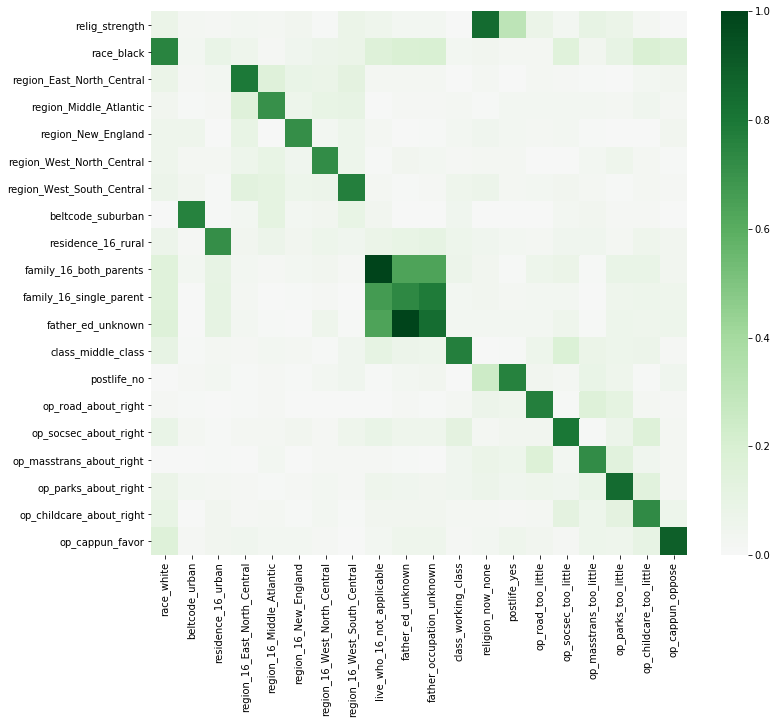

In [113]:
plt.figure(figsize=(12, 10))
sns.heatmap(most_collinear,
           cmap='PRGn',
           center=0)
plt.show()

In [114]:
## Drop things on x axis

## live_who_16_not_applicable is because it's the same as living with both parents - remove.

## Region at 16 very correlated with region now
## Could do a variable to see whether it has changed
## This is already covered in geo mobility
## Drop region at 16 for variables mentioned

## Also drop one answer to each opinion question
## Covered via other answers

## Same for religion now = none
## Same for beltcode urban
## Same for residence 16 urban
## Same for race white
## Same for father ed unknown and father occ unknown
## Same for working class

x_train.drop(columns=['live_who_16_not_applicable',
                      'region_16_East_North_Central', 
                      'region_16_Middle_Atlantic', 
                      'region_16_New_England', 
                      'region_16_West_North_Central',
                      'region_16_West_South_Central',
                      'postlife_yes', 
                      'op_road_too_little',
                      'op_socsec_too_little',
                      'op_masstrans_too_little',
                      'op_parks_too_little',
                      'op_childcare_too_little',
                      'op_scires_too_little',
                      'op_cappun_oppose',
                      'religion_now_none',
                      'beltcode_urban',
                      'residence_16_urban',
                      'race_white',
                      'father_ed_unknown',
                      'father_occupation_unknown',
                      'class_working_class'], inplace=True)
x_test.drop(columns=['live_who_16_not_applicable',
                     'region_16_East_North_Central', 
                      'region_16_Middle_Atlantic', 
                      'region_16_New_England', 
                      'region_16_West_North_Central',
                      'region_16_West_South_Central',
                      'postlife_yes', 
                      'op_road_too_little',
                      'op_socsec_too_little',
                      'op_masstrans_too_little',
                      'op_parks_too_little',
                      'op_childcare_too_little',
                      'op_scires_too_little',
                      'op_cappun_oppose',
                      'religion_now_none',
                      'beltcode_urban',
                      'residence_16_urban',
                      'race_white',
                      'father_ed_unknown',
                      'father_occupation_unknown',
                      'class_working_class'], inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


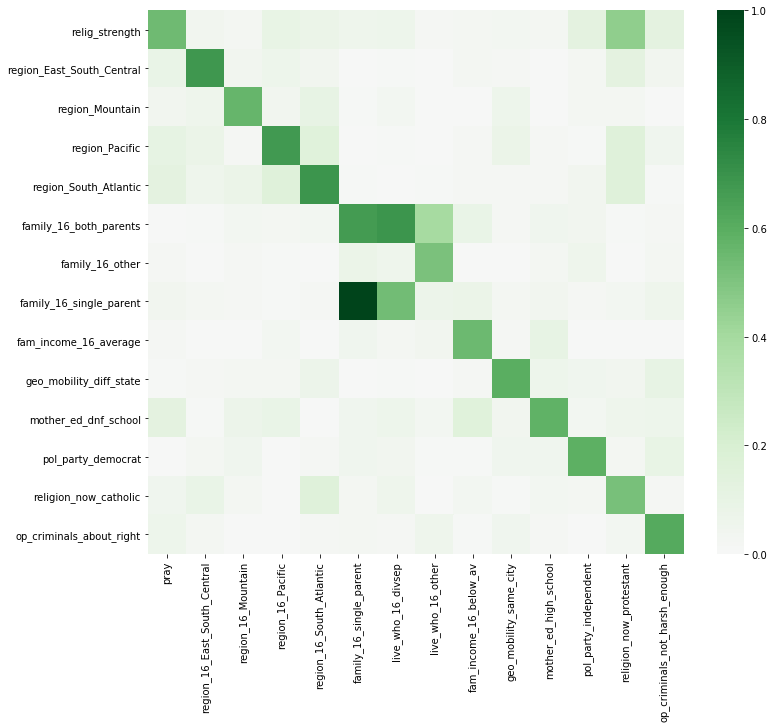

In [115]:
## Could drop variables up to 0.5 correlation
## Leave for now

corr_matrix2 = x_train.corr().abs()
upper2 = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
lower2 = corr_matrix2.where(np.tril(np.ones(corr_matrix2.shape), k=-1).astype(np.bool))
collinear_features2 = [column for column in upper2.columns if any(upper2[column] > 0.50)]
collinear_features2a = [column for column in lower2.columns if any(lower2[column] > 0.50)]
most_collinear2 = corr_matrix2.loc[collinear_features2a, collinear_features2]
plt.figure(figsize=(12, 10))
sns.heatmap(most_collinear2,
           cmap='PRGn',
           center=0)
plt.show()

In [116]:
x_train.shape

(3324, 174)

In [117]:
y_train.sum()

1118

## Transform continuous variables to be normal shaped

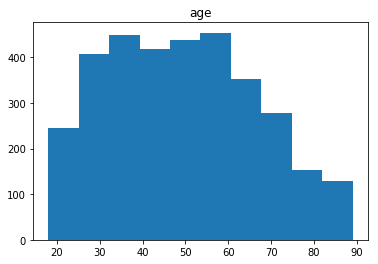

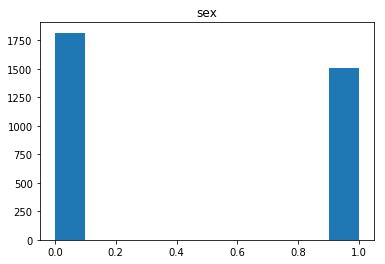

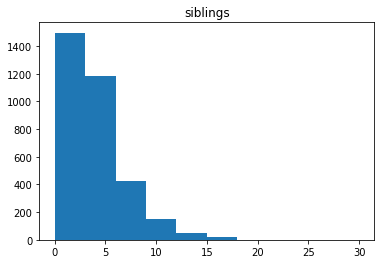

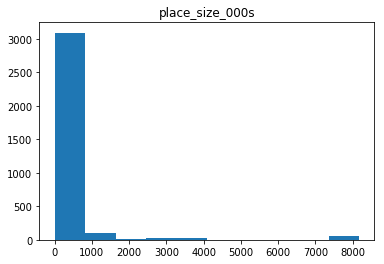

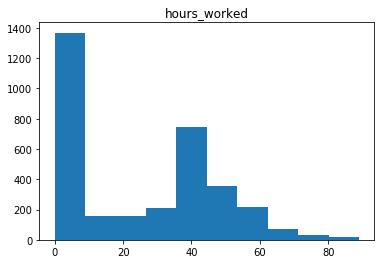

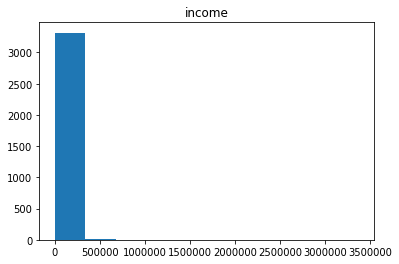

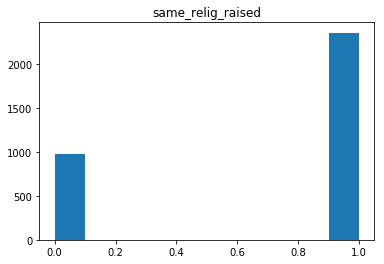

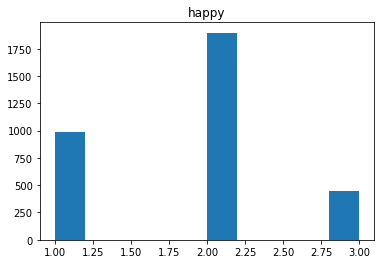

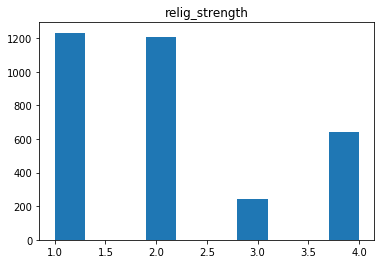

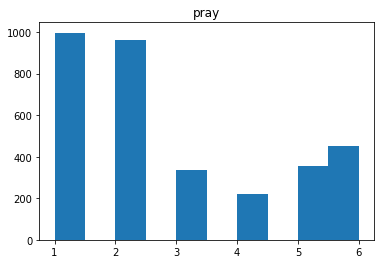

In [118]:
## View continuous variable shapes

for i in np.arange(0, 10):
    plt.hist(x_train.iloc[:, i])
    plt.title(x_train.columns[i])
    plt.show()

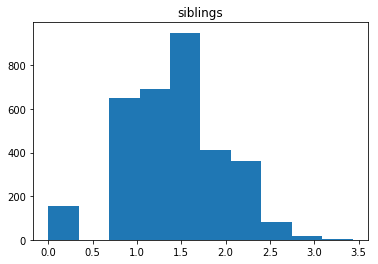

In [119]:
## This looks better

plt.hist(np.log(x_train.loc[:, 'siblings']+1))
plt.title('siblings')
plt.show()

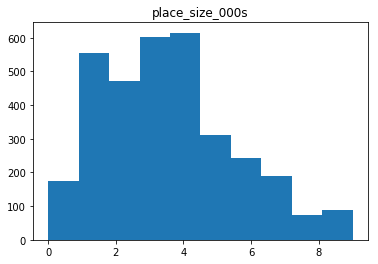

In [120]:
## This looks better

plt.hist(np.log(x_train.loc[:, 'place_size_000s']+1))
plt.title('place_size_000s')
plt.show()

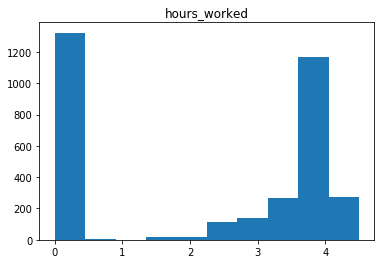

In [121]:
## This does not look better

plt.hist(np.log(x_train.loc[:, 'hours_worked']+1))
plt.title('hours_worked')
plt.show()

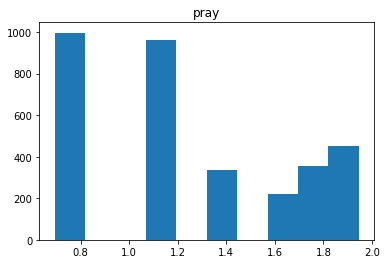

In [122]:
## This does not look better

plt.hist(np.log(x_train.loc[:, 'pray']+1))
plt.title('pray')
plt.show()

In [123]:
## Tranforms to include:

x_train['siblings_log'] = np.log(x_train['siblings']+1)
x_train['place_size_000s_log'] = np.log(x_train['place_size_000s']+1)
x_train.drop(columns=['siblings', 'place_size_000s'], inplace=True)

x_test['siblings_log'] = np.log(x_test['siblings']+1)
x_test['place_size_000s_log'] = np.log(x_test['place_size_000s']+1)
x_test.drop(columns=['siblings', 'place_size_000s'], inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [124]:
x_train.head()

,age,sex,hours_worked,income,same_relig_raised,happy,relig_strength,pray,race_american_indian,race_black,...,op_scires_dont_know,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh,siblings_log,place_size_000s_log
3580,32.0,0,40.0,32500.000000,1,2.0,2.0,4.0,0,0,...,0,0,0,1,0,0,1,0,1.098612,2.302585
4369,52.0,0,0.0,21938.115530,1,3.0,2.0,2.0,0,0,...,0,0,0,1,0,0,1,0,1.609438,1.945910
3999,84.0,0,0.0,37190.263268,1,1.0,1.0,2.0,0,0,...,0,0,0,1,0,0,1,0,1.945910,3.496508
192,22.0,1,20.0,21250.000000,0,1.0,1.0,5.0,0,0,...,0,1,0,0,1,0,0,0,1.609438,2.197225
3996,23.0,0,0.0,11250.000000,1,2.0,2.0,1.0,0,0,...,0,0,0,0,0,0,0,1,1.386294,3.496508


## Data variations

### Scaling

#### StandardScaler
This is a standardization scaler - all variables mean 0 var 1.

In [125]:
standard_scaler = preprocessing.StandardScaler().fit(x_train)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [126]:
standard_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [127]:
x_train_ss = standard_scaler.transform(x_train)
x_test_ss = standard_scaler.transform(x_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


#### MinMaxScaler
This is a normalization scaler - all variables in range 0 to 1.

In [128]:
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [129]:
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [130]:
x_train_mm = min_max_scaler.transform(x_train)
x_test_mm = min_max_scaler.transform(x_test)

## PCA

#### StandardScaler data

In [132]:
pca_ss = PCA()
pca_ss.fit(x_train_ss)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [138]:
pca_ss.explained_variance_[:10]

array([5.0724933 , 3.79136086, 3.42424698, 2.91746056, 2.514244  ,
       2.31843554, 2.25946005, 2.20099787, 2.0507507 , 2.01343748])

In [141]:
sum(pca_ss.explained_variance_ > 1)

78

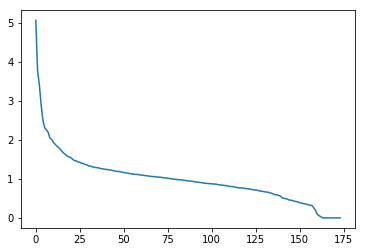

In [139]:
plt.plot(pca_ss.explained_variance_)
plt.show()

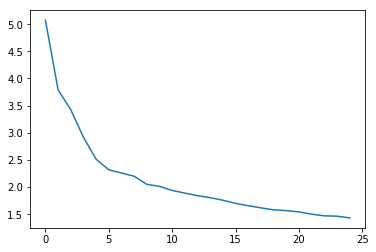

In [143]:
plt.plot(pca_ss.explained_variance_[:25])
plt.show()

In [144]:
## drastic change at point 5 - keep only 5?

##pca_ss = PCA(n_components = 5)
##pca_ss.fit(x_train_ss)
##x_train_ss_pca = pca_ss.transform(x_train_ss)
##x_test_ss_pca = pca_ss.transform(x_test_ss)

#### MinMaxScaler data

In [145]:
pca_mm = PCA()
pca_mm.fit(x_train_mm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [146]:
pca_mm.explained_variance_[:10]

array([0.66984672, 0.59649421, 0.55726042, 0.4659343 , 0.42891324,
       0.40036844, 0.35010119, 0.34192636, 0.31195455, 0.30470883])

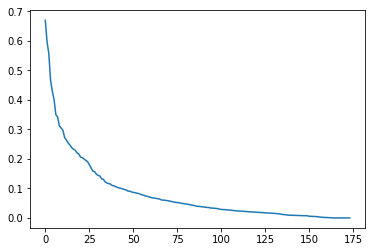

In [147]:
plt.plot(pca_mm.explained_variance_)
plt.show()

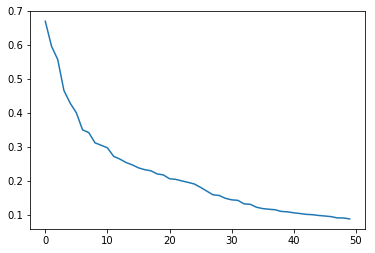

In [148]:
plt.plot(pca_mm.explained_variance_[:50])
plt.show()

In [149]:
## Changes after about 11? Or maybe 27?

##pca_mm = PCA(n_components=11)
##pca_mm.fit(x_train_mm)
##x_train_mm_pca = pca_mm.transform(x_train_mm)
##x_test_mm_pca = pca_mm.transform(x_test_mm)

## Preparing nested cross validation

### KNN
#### Unscaled data

In [206]:
knn = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': np.arange(1, 31), 
                  'weights': ['uniform', 'distance']}

In [207]:
inner_cv = StratifiedKFold(n_splits=5, random_state=5322)
outer_cv = StratifiedKFold(n_splits=10, random_state=5322)

In [208]:
knn_inner = GridSearchCV(estimator=knn, 
                         param_grid=knn_param_grid,
                         cv=inner_cv,
                         verbose=10)

In [210]:
start = time.clock()
knn_scores = cross_validate(knn_inner, 
                            x_train, 
                            y_train,
                            scoring='accuracy',
                            cv=outer_cv,
                            n_jobs=2,
                            verbose=10,
                            return_estimator=True)
print(time.clock() - start)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.4min


0.5681390000000022


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  6.0min finished
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


In [211]:
knn_scores

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([69.14529204, 69.41971517, 71.89318991, 70.80280304, 75.26989007,
        74.24636626, 70.25637674, 70.41429305, 68.89707375, 69.74057388]),
 'score_time': array([0.03233314, 0.02831507, 0.05433393, 0.03043699, 0.0348978 ,
        0.0289669 , 0.03366208, 0.03800869, 0.03203106, 0.02844119]),
 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=False),
         error_score='raise-deprecating',
         estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'),
         fit_params=None, iid='warn', n_jobs=None,
         param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'weights': ['uniform', 'distance']},
         pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
         scoring=None, ver

In [212]:
start = time.process_time()
knn_scores_f1 = cross_validate(knn_inner, 
                               x_train, 
                               y_train, 
                               scoring='f1',
                               cv=outer_cv,
                               n_jobs=2,
                               verbose=10,
                               return_estimator=True)
print(time.process_time() - start)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.5min


0.46489199999999187


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  5.9min finished


In [213]:
knn_scores_f1

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([74.52329707, 74.75321174, 74.98834205, 73.95401025, 71.31198716,
        70.40957808, 70.57052875, 70.75005221, 62.84848285, 63.66065788]),
 'score_time': array([0.04126   , 0.02972007, 0.03802872, 0.03155088, 0.03878808,
        0.03544903, 0.03291512, 0.03097773, 0.03146887, 0.02857709]),
 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=False),
         error_score='raise-deprecating',
         estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'),
         fit_params=None, iid='warn', n_jobs=None,
         param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'weights': ['uniform', 'distance']},
         pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
         scoring=None, ver

#### StandardScaler data

In [ ]:
start = time.clock()
knn_scores_ss = cross_validate(knn_inner, 
                               x_train_ss, 
                               y_train,
                               scoring='accuracy',
                               cv=outer_cv,
                               n_jobs=2,
                               verbose=10,
                               return_estimator=True)
print(time.clock() - start)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 11.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 23.0min


In [ ]:
knn_scores_ss

In [ ]:
start = time.process_time()
knn_scores_ss_f1 = cross_validate(knn_inner, 
                                  x_train_ss, 
                                  y_train, 
                                  scoring='f1',
                                  cv=outer_cv,
                                  n_jobs=2,
                                  verbose=10,
                                  return_estimator=True)
print(time.process_time() - start)

In [ ]:
knn_scores_ss_f1

#### MinMaxScaler data

In [ ]:
start = time.clock()
knn_scores_mm = cross_validate(knn_inner, 
                               x_train_mm, 
                               y_train,
                               scoring='accuracy',
                               cv=outer_cv,
                               n_jobs=2,
                               verbose=10,
                               return_estimator=True)
print(time.clock() - start)

In [ ]:
knn_scores_mm

In [ ]:
start = time.process_time()
knn_scores_mm_f1 = cross_validate(knn_inner, 
                                  x_train_mm, 
                                  y_train, 
                                  scoring='f1',
                                  cv=outer_cv,
                                  n_jobs=2,
                                  verbose=10,
                                  return_estimator=True)
print(time.process_time() - start)

In [ ]:
knn_scores_mm_f1

In [ ]:
## Things that are interesting
## Graph showing how F1 score changes with neighbors


## How to split manually

##outer_folds = StratifiedKFold(n_splits=5, random_state=5322)
##outer_arry_ls_x_train=[]
##outer_arry_ls_x_test=[]

##for train, test in outer_folds.split(x_train, y_train):
##    x_outer_train, x_outer_test = x_train.iloc[train], x_train.iloc[test]
##   outer_arry_ls_x_train.append(x_outer_train)
##    outer_arry_ls_x_test.append(x_outer_test)
##    y_outer_train, y_outer_test = y_train.iloc[train], y_train.iloc[test]